# **Introduction**

This is an initial Explanatory Data Analysis for the [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge#description) with matplotlib. [bokeh](https://bokeh.pydata.org/en/latest/) and [Plot.ly](https://plot.ly/feed/) - a visualization tool that creates beautiful interactive plots and dashboards.  The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective to predict an accurate price that Mercari should suggest to its sellers, given the item's information. 

***Update***: The abundant amount of food from my family's Thanksgiving dinner has really energized me to continue working on this model. I decided to dive deeper into the NLP analysis and found an amazing tutorial by Ahmed BESBES. The framework below is  based on his [source code](https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html).  It provides guidance on pre-processing documents and  machine learning techniques (K-means and LDA) to clustering topics.  So that this kernel will be divided into 2 parts: 

1. Explanatory Data Analysis 
2. Text Processing  
    2.1. Tokenizing and  tf-idf algorithm  
    2.2. K-means Clustering  
    2.3. Latent Dirichlet Allocation (LDA)  / Topic Modelling
 

In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

# **Exploratory Data Analysis**
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary. 

1. **Numerical/Continuous Features**
    1. price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    2. shipping cost     
 
1. **Categorical Features**: 
    1. shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    2. item_condition_id: The condition of the items provided by the seller
    1. name: The item's name
    2. brand_name: The item's producer brand name
    2. category_name: The item's single or multiple categories that are separated by "\" 
    3. item_description: A short description on the item that may include removed words, flagged by [rm]

In [2]:
PATH = "../input/"

In [3]:
#train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
#test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

train = pd.read_csv('../../../data/train.tsv', sep='\t')
test = pd.read_csv('../../../data/test.tsv', sep='\t')

train = train.loc[train.item_description == train.item_description]
train = train.loc[train.name == train.name]
print("Dropped records where item description was nan")


Dropped records where item description was nan


In [4]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482531, 8)
(693359, 7)


In [5]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Target Variable: **Price**

The next standard check is with our response or target variables, which in this case is the `price` we are suggesting to the Mercari's marketplace sellers.  The median price of all the items in the training is about \$267 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [ ]:
train.price.describe()

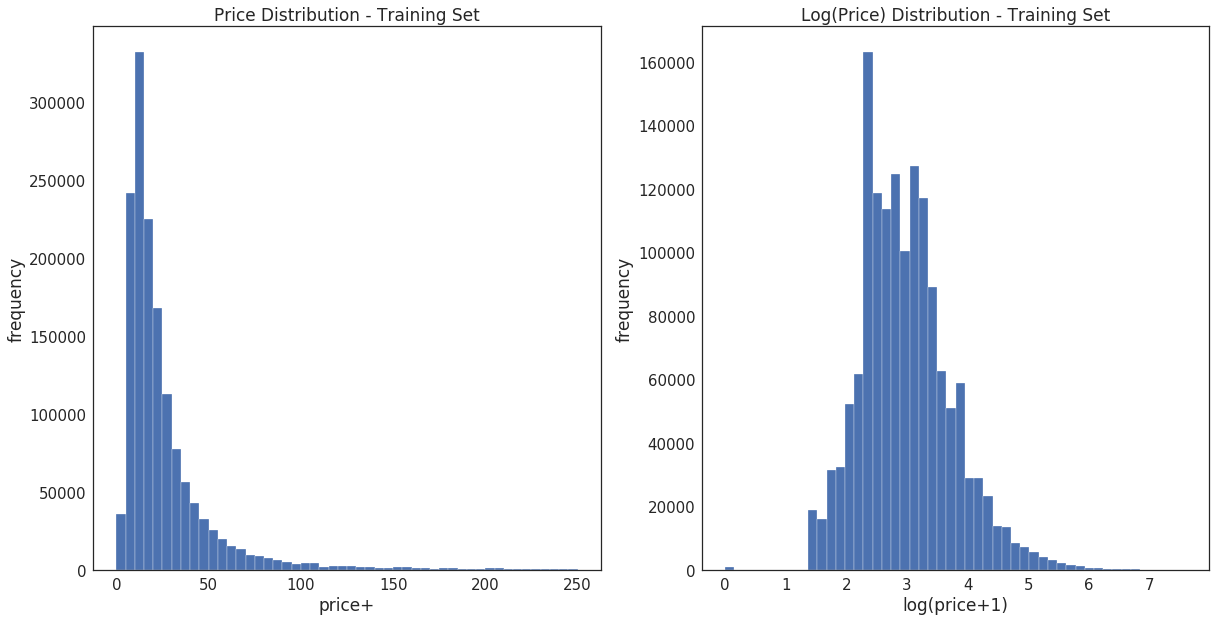

In [7]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

## **Shipping**

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [ ]:
train.shipping.value_counts()/len(train)

In [ ]:
prc_shipBySeller = train.loc[train.shipping==0, 'price']
prc_shipByBuyer = train.loc[train.shipping==1, 'price']

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

## **Item Category**

There are about **1,287** unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the `brand_name` column will impact the model's prediction. 

In [8]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [9]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29909
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [10]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [11]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [12]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [13]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [14]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [15]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


Overall, we have  **7 main categories** (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics. 

In [16]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [ ]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [ ]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_2'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [ ]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by SubCategory (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point 

In [ ]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [ ]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [ ]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

# **Text Processing - Item Description**
*
The following section is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html*

## **Pre-processing:  tokenization**

Most of the time, the first steps of an NLP project is to **"tokenize"** your documents, which main purpose is to normalize our texts. The three fundamental stages will usually include: 
* break the descriptions into sentences and then break the sentences into tokens
* remove punctuation and stop words
* lowercase the tokens
* herein, I will also only consider words that have length equal to or greater than 3 characters

In [17]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3. 

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

In [20]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
#vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

## **Latent Dirichlet Allocation**

Latent Dirichlet Allocation (LDA) is an algorithms used to discover the topics that are present in a corpus.

>  LDA starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.
> 
> Reference: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

Its input is a **bag of words**, i.e. each document represented as a row, with each columns containing the count of words in the corpus. We are going to use a powerful tool called pyLDAvis that gives us an interactive visualization for LDA. 

In [21]:
from time import time
def startTime():
    return time()
def endTime(s):
    print("Time elapsed is {}".format(time() - s))

In [22]:

cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))


In [23]:
s = time()
cvz = cvectorizer.fit_transform(combined_sample['item_description'])
endTime(s)

Time elapsed is 4.761543035507202


In [24]:
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [25]:
s = time()
X_topics = lda_model.fit_transform(cvz)
endTime(s)

Time elapsed is 57.781503438949585


In [26]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: condition | size | worn | good | great | like | used | good condition | pink | great condition
Topic 1: size | tags | large | black | small | new | top | new tags | back | dress
Topic 2: free | shipping | home | free shipping | smoke | free home | smoke free | new | size | super
Topic 3: bundle | save | shipping | bundle save | inches | check | offers | listings | hair | items
Topic 4: please | shipping | free | ask | day | questions | item | items | ship | bundle
Topic 5: price | firm | make | price firm | shipping | buy | know | get | let | want
Topic 6: description | yet | description yet | still | condition | great | perfect | little | see | picture
Topic 7: one | worn | never | never worn | two | red | lularoe | without | leggings | new
Topic 8: new | brand | brand new | used | never | box | never used | new never | authentic | color
Topic 9: iphone | case | plus | quality | use | phone | high | works | charger | included


In [27]:
# reduce dimension to 2 using tsne
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.010s...
[t-SNE] Computed neighbors for 15000 samples in 2.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [28]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
combined_sample = combined_sample.reset_index()
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [29]:
from bokeh.plotting import figure, show, output_notebook
plot_lda = bp.figure(plot_width=800,
                     plot_height=700,
                     title="LDA topic visualization"
                     ,x_axis_label='t-SNE Dim 1', y_axis_label='t-SNE Dim 2')
                     #x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.title.text_font_size = '40pt'
plot_lda.xaxis.axis_label_text_font_size = "35pt"
plot_lda.yaxis.axis_label_text_font_size = "35pt"
plot_lda.title.align = 'center'

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [32]:
%matplotlib inline
#from bokeh.plotting import figure, show, output_notebook
output_notebook()
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(lda_df['x'], lda_df['y'], color=colormap[lda_keys])
#plot_lda.scatter(source=source, x='x', y='y', color='color')
#hover = plot_kmeans.select(dict(type=HoverTool))
#hover = plot_lda.select(dict(type=HoverTool))
#hover.tooltips={"description":"@description",
#                "topic":"@topic", "category":"@category"}
show(plot_lda)


Loading BokehJS ...

> ## Box Plot : Topics vs Price

(10,)

In [42]:
len(my_plot)

10

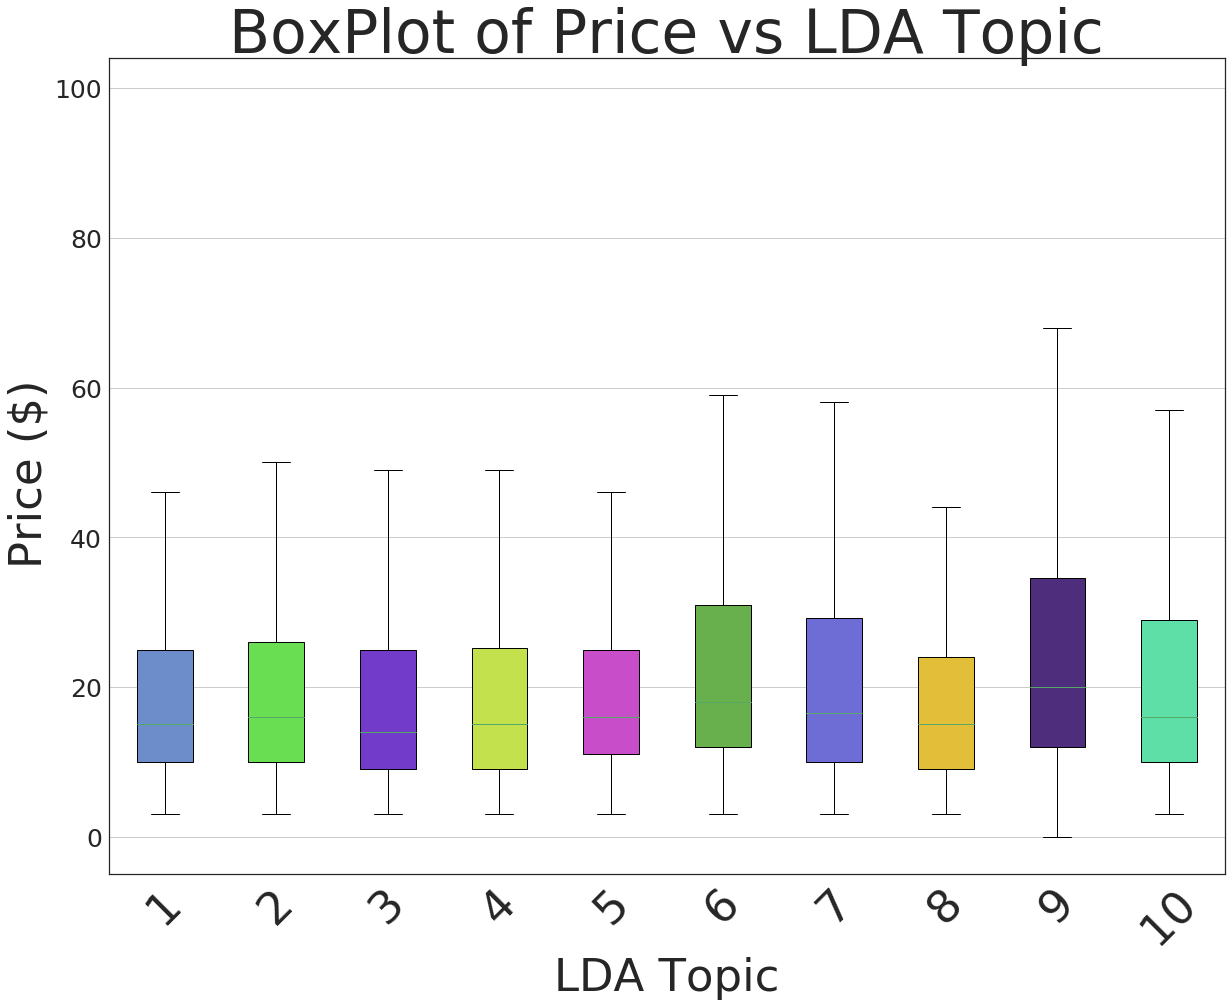

In [48]:
lda_df['price'] = combined_sample['price']
df = lda_df[lda_df['price']<100]

df['topic'].unique()

my_plot = []
for i in df['topic'].unique():
    my_plot.append(df[df['topic']==i]['price'])

fig, axes = plt.subplots(figsize=(20, 15))
bp = axes.boxplot(my_plot,vert=True,patch_artist=True,labels=range(1,n_topics+1)) 

#colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
colors = colormap[:n_topics]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes.yaxis.grid(True)

plt.title('BoxPlot of Price vs LDA Topic', fontsize=60)
plt.xlabel('LDA Topic', fontsize=45)
plt.ylabel('Price ($) ', fontsize=45)
plt.xticks(fontsize=45)
plt.yticks(fontsize=25)
plt.xticks(rotation=45)
plt.show()

fig.savefig('trainPrice_vs_Itm_Cdtn_Id.png', bbox_inches='tight')
del df


*Note: It's a shame that by putting the HTML of the visualization using pyLDAvis will distort the layout of the kernel, I will not upload in here. But if you follow the below code, there should be an HTML file generated with very interesting interactive bubble chart that visualize the space of your topic clusters and the term components within each topic.*

![](https://www.flickr.com/photos/thykhuely/38709272151)

In [ ]:
import pyLDAvis

lda_df['len_docs'] = combined_sample['tokens'].map(len)
ldadata = prepareLDAData()
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)

<a data-flickr-embed="true"  href="https://www.flickr.com/photos/thykhuely/38709272151/in/dateposted-public/" title="pyLDAvis"><img src="https://farm5.staticflickr.com/4536/38709272151_7128c577ee_h.jpg" width="1600" height="976" alt="pyLDAvis"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

In [ ]:
import IPython.display
from IPython.core.display import display, HTML, Javascript

h = IPython.display.display(HTML(html_string))
#IPython.display.display_HTML(h)